In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sqlalchemy import create_engine, text

from evidently.dashboard import Dashboard
from evidently.report import Report
from evidently.metric_preset import DataDriftPreset, DataQualityPreset
from evidently.dashboard.tabs import DataDriftTab, CatTargetDriftTab

from flask import Flask

/opt/conda/lib/python3.11/site-packages/evidently/analyzers/__init__.py:3: UserWarning: analyzers are deprecated, use metrics instead
  warnings.warn("analyzers are deprecated, use metrics instead")
/opt/conda/lib/python3.11/site-packages/evidently/dashboard/__init__.py:8: UserWarning: dashboards are deprecated, use metrics instead
  warnings.warn("dashboards are deprecated, use metrics instead")


In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [3]:
db_user = 'postgres'
db_password = 'postgres'
db_host = 'db'  
db_name = 'postgres'

In [4]:
engine = create_engine(f'postgresql://{db_user}:{db_password}@{db_host}:5432/{db_name}')

In [5]:
with engine.begin() as conn:
    query = text("""
    SELECT * 
    FROM titanic_train
    """)
    df_pg = pd.read_sql_query(query, conn)

In [6]:
df_pg.head(5)

,index,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,None,S
1,1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,None,S
3,3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,None,S


<AxesSubplot: xlabel='Survived', ylabel='Count'>

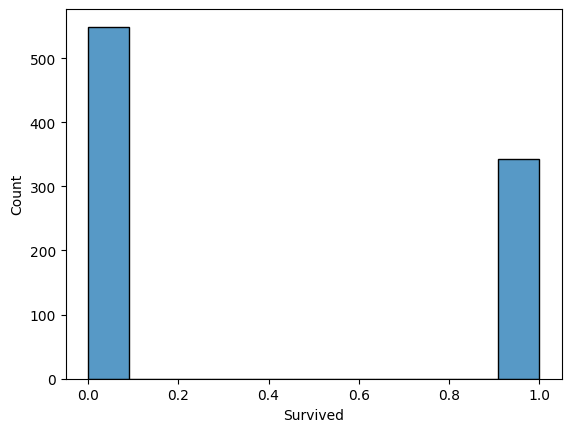

In [7]:
sns.histplot(data=df_pg,x='Survived')

In [7]:
df_pg.rename(columns={'Survived':'target'},inplace=True)

In [8]:
dashboard = Dashboard(tabs=[DataDriftTab()])
dashboard.calculate(df_pg, df_pg)

In [9]:
titanic_target_drift_dashboard = Dashboard(tabs=[CatTargetDriftTab(verbose_level=1)])

In [10]:
titanic_target_drift_dashboard.calculate(df_pg, df_pg, column_mapping=None)

In [11]:
from IPython.core.display import display
display(titanic_target_drift_dashboard.show())

In [13]:
titanic_target_drift_dashboard.save("titanic_target_drift_dashboard.html")

In [12]:
with engine.begin() as conn:
    query = text("""
    SELECT * 
    FROM titanic_test
    """)
    df_pg_test = pd.read_sql_query(query, conn)

In [13]:
df_pg_test.head(5)

,index,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,None,Q
1,1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,None,S
2,2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,None,Q
3,3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,None,S
4,4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,None,S


In [14]:
df_pg.head(5)

,index,PassengerId,target,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,None,S
1,1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,None,S
3,3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,None,S


In [15]:
#Сравнение старых данных и новых данных
data_quality_report = Report(metrics=[
    DataQualityPreset(),
])

data_quality_report.run(reference_data=df_pg.drop(columns='target'), current_data=df_pg_test)
data_quality_report

In [14]:
data_quality_report.show()

In [15]:
data_quality_report.save_html("data_quality_report.html")